# Multivariable linear regression

Author: Heitor L. Werneck

Dataset source: https://www.kaggle.com/farhanmd29/50-startups

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
from pandas.plotting import table

import re
import math

from LinearRegression import LinearRegression

pd.set_option("display.precision", 3)

TO_PREDICT_COLUMN_NAME = "Profit"
FILE_NAME = "../50_Startups.csv" # Input file name (dataset)
TRAIN_SIZE = 0.7
TEST_SIZE = 1-TRAIN_SIZE
SEED = 518374674 # Seed to random generators

DIR = "../doc/"

class FileName:
    PREDICTED_FUNCTION = DIR+"predicted_function.png"
    CITIES_PARAMETERS = DIR+"cities_parameters.png"
    ERROR = DIR+"error.png"
    DATA_SET = DIR+"data_set.png"
    ABS_REL_ERROR = DIR+"abs_rel_error.png"
    ABS_REL_ERROR_DES = DIR+"abs_rel_error_des.png"
    
def plot_df(df,filename):
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_frame_on(False)
    tabla = table(ax, df, loc='upper right', colWidths=[0.17]*len(df.columns))  # where df is your data frame
    tabla.auto_set_font_size(False)
    tabla.set_fontsize(12)
    tabla.scale(1.2, 1.2)
    plt.savefig(filename, transparent=True)

# Dataset lookup

In [2]:
df = pd.read_csv(FILE_NAME)

In [3]:
df.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [4]:
corr = df.corr()

In [5]:
corr.style.background_gradient(cmap='viridis').set_precision(2)

,R&D Spend,Administration,Marketing Spend,Profit
R&D Spend,1,0.24,0.72,0.97
Administration,0.24,1,-0.032,0.2
Marketing Spend,0.72,-0.032,1,0.75
Profit,0.97,0.2,0.75,1


## Inserting a dummy column and transforming string column to dummies variables/columns

In [6]:
df['dummy'] = 1

In [7]:
df = pd.get_dummies(df)
df.head(2)

,R&D Spend,Administration,Marketing Spend,Profit,dummy,State_California,State_Florida,State_New York
0,165349.2,136897.80,471784.10,192261.83,1,0,0,1
1,162597.7,151377.59,443898.53,191792.06,1,1,0,0


In [8]:
df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)

In [9]:
df.head(2)

,R&D Spend,Administration,Marketing Spend,Profit,dummy,State_California,State_Florida,State_New York
0,46014.02,85047.44,205517.64,96479.51,1,0,0,1
1,72107.60,127864.55,353183.81,105008.31,1,0,0,1


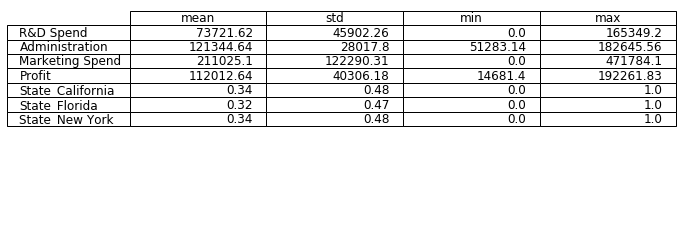

In [10]:
df_described = df.describe().loc[['mean','std','min','max'],df.columns != 'dummy'].T.round(2)

plot_df(df_described,FileName.DATA_SET)

## Separate column to predict and features columns

In [11]:
x = df.loc[:,df.columns!=TO_PREDICT_COLUMN_NAME]
y = df.loc[:,df.columns==TO_PREDICT_COLUMN_NAME]

In [12]:
features_name = list(x.columns)

## Separate train and test

In [13]:
x_train, x_test, y_train, y_test = x.loc[:np.ceil(x.shape[0]*TRAIN_SIZE)],\
                                    x.loc[np.floor(x.shape[0]*TRAIN_SIZE)+1:],\
                                    y.loc[:np.ceil(y.shape[0]*TRAIN_SIZE)],\
                                    y.loc[np.floor(y.shape[0]*TRAIN_SIZE)+1:],\

x_train, x_test, y_train, y_test = x_train.to_numpy(),x_test.to_numpy(),\
                                    y_train.to_numpy(),y_test.to_numpy()

## Use linear regression in the data

In [14]:
lr = LinearRegression()
lr.fit(x_train,y_train)
print(lr.to_string_predict_function(TO_PREDICT_COLUMN_NAME,features_name))

Profit(R&D Spend,...) = (0.823)*R&D Spend+(-0.0483)*Administration+(0.0301)*Marketing Spend+(5.17e+04)*dummy+(-9.32e+02)*State_California+(-5.92e+02)*State_Florida+(1.98e+03)*State_New York


In [15]:
# a = lr.to_latex_predict_function(TO_PREDICT_COLUMN_NAME,features_name)

# ax = plt.axes([0,0,0.3,0.3])
# ax.set_xticks([])
# ax.set_yticks([])
# ax.axis('off')
# plt.text(0.4,0.4,'$%s$' %a,size=20,color="black")
# plt.show()
# plt.savefig(FileName.PREDICTED_FUNCTION)

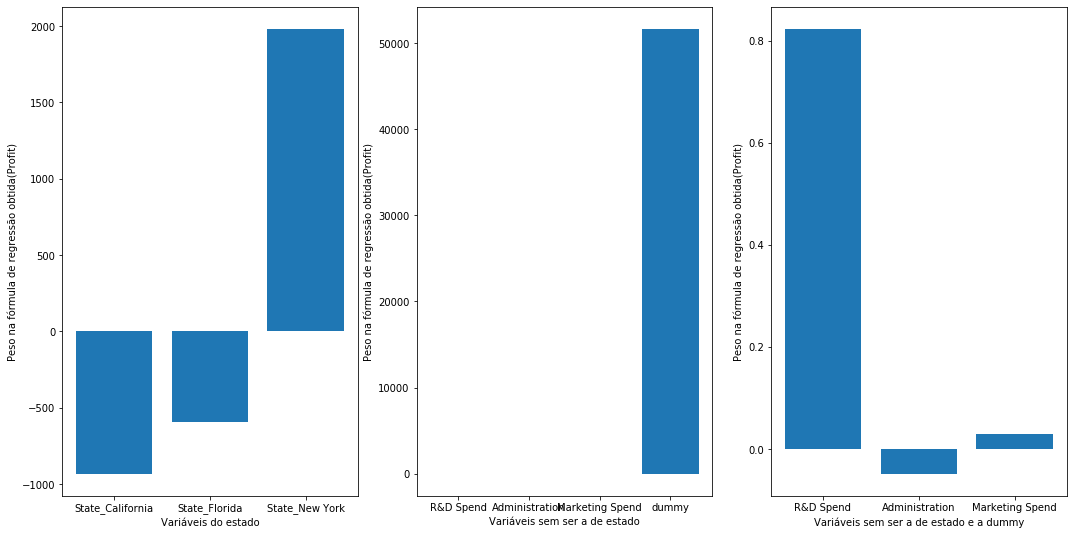

In [16]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3, figsize=(18,9))

positions = []
state_features = list(filter(lambda x : re.search(r"State.*",x) ,features_name))
for feature in state_features:
    positions.append(features_name.index(feature))
    
ax1.bar(state_features,lr.parameters[positions])
ax1.set_xlabel("Variáveis do estado")
ax1.set_ylabel("Peso na fórmula de regressão obtida(Profit)")


positions = []
not_state_features = list(filter(lambda x : re.search(r"^(?!State)",x) ,features_name))
for feature in not_state_features:
    positions.append(features_name.index(feature))
ax2.bar(not_state_features,lr.parameters[positions])
ax2.set_xlabel("Variáveis sem ser a de estado")
ax2.set_ylabel("Peso na fórmula de regressão obtida(Profit)")

positions = []
not_dummy_state_features = list(filter(lambda x : re.search(r"^(?!((State)|^(dummy)))",x) ,features_name))
for feature in not_dummy_state_features:
    positions.append(features_name.index(feature))



ax3.bar(not_dummy_state_features,lr.parameters[positions])
ax3.set_xlabel("Variáveis sem ser a de estado e a dummy")
ax3.set_ylabel("Peso na fórmula de regressão obtida(Profit)")

fig.savefig(FileName.CITIES_PARAMETERS)


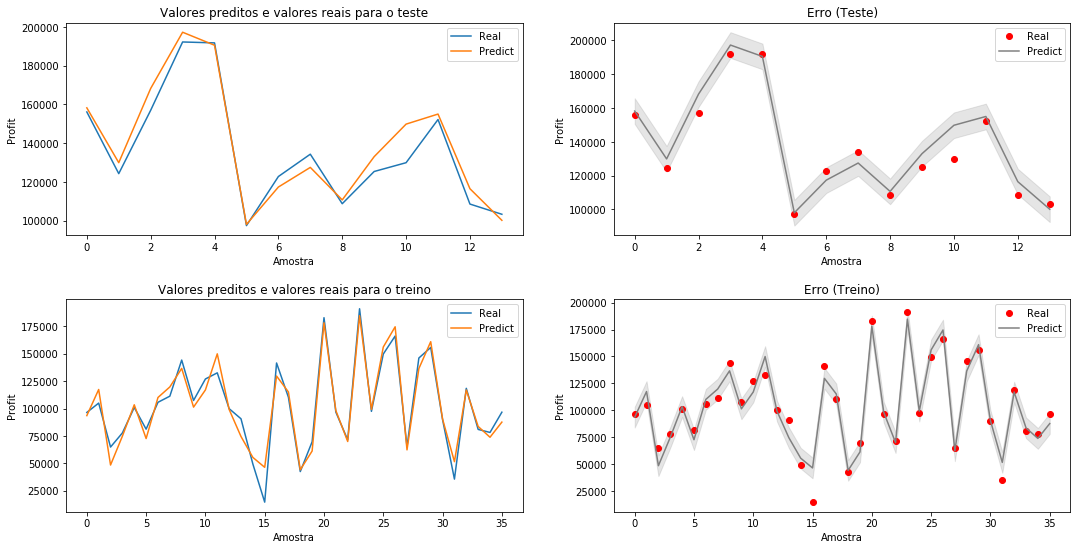

In [17]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(18,9))
fig.subplots_adjust(wspace=0.2,hspace=0.3)

ax1.plot(np.arange(y_test.shape[0]),
         y_test.flatten(),
         np.arange(y_test.shape[0]),
         lr.predict(x_test).flatten(),
        )
ax1.set_title("Valores preditos e valores reais para o teste")
ax1.set_xlabel("Amostra")
ax1.set_ylabel("Profit")
ax1.legend(['Real','Predict'])

ax2.plot(np.arange(y_test.shape[0]), y_test.flatten(), 'or')
ax2.plot(np.arange(y_test.shape[0]), lr.predict(x_test).flatten(), '-', color='gray')

dyfit = lr.rmse(y_test)

ax2.fill_between(np.arange(y_test.shape[0]), lr.predict(x_test).flatten() - dyfit, 
                 lr.predict(x_test).flatten() + dyfit,
                 color='gray', alpha=0.2)

ax2.set_title("Erro (Teste)")
ax2.set_xlabel("Amostra")
ax2.set_ylabel("Profit")
ax2.legend(['Real','Predict'])

ax3.plot(np.arange(y_train.shape[0]),
         y_train.flatten(),
         np.arange(y_train.shape[0]),
         lr.predict(x_train).flatten(),
        )
ax3.set_title("Valores preditos e valores reais para o treino")
ax3.set_xlabel("Amostra")
ax3.set_ylabel("Profit")
ax3.legend(['Real','Predict'])

ax4.plot(np.arange(y_train.shape[0]), y_train.flatten(), 'or')
ax4.plot(np.arange(y_train.shape[0]), lr.predict(x_train).flatten(), '-', color='gray')

dyfit = lr.rmse(y_train)

ax4.fill_between(np.arange(y_train.shape[0]), lr.predict(x_train).flatten() - dyfit, 
                 lr.predict(x_train).flatten() + dyfit,
                 color='gray', alpha=0.2)

ax4.set_title("Erro (Treino)")
ax4.set_xlabel("Amostra")
ax4.set_ylabel("Profit")
ax4.legend(['Real','Predict'])
fig.savefig(FileName.ERROR)

In [18]:
print(f"Test R^2={lr.score(x_test,y_test)}")
print(f"Train R^2={lr.score(x_train,y_train)}")
print(f"Test Adjusted R^2={lr.adjusted_r2(x_test,y_test)}")
print(f"Train Adjusted R^2={lr.adjusted_r2(x_train,y_train)}")

Test R^2=0.9322459312244412
Train R^2=0.9412133523575299
Test Adjusted R^2=0.853199517652956
Train Adjusted R^2=0.9265166904469123


In [19]:
df = pd.DataFrame()

In [20]:
df['real'] = y_test.flatten()

In [21]:
df['predicted'] = lr.predict(x_test).flatten()

In [22]:
df['absolute_error'] = lr.absolute_error(y_test).flatten()

In [23]:
df['relative_error'] = lr.relative_error(y_test).flatten()

In [24]:
metrics = [
    ("MSE",lr.mse),
    ("RMSE",lr.rmse),
    ("RRMSE",lr.rrmse),
    ("MAE",lr.mae),
    ("MAPE",lr.mape),
    ("RMSLE",lr.rmsle),
]

for metric_name, metric_function in metrics:
    print(metric_name,metric_function(y_test))

MSE 57624666.284417234
RMSE 7591.091244637838
RRMSE 0.06956706362289085
MAE 5828.124952610224
MAPE 0.04422778830100514
RMSLE 0.05537110299114828


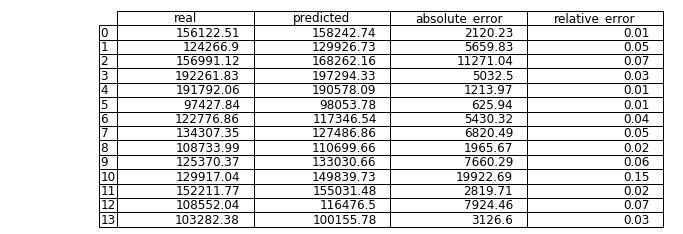

In [25]:
df = df.round(2)

plot_df(df,FileName.ABS_REL_ERROR)

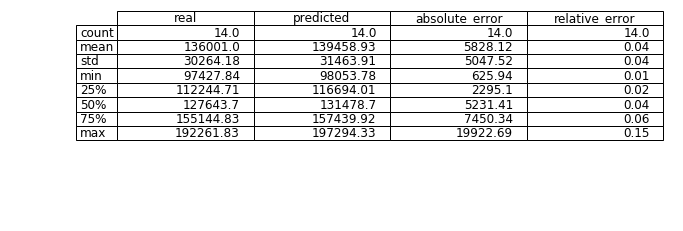

In [26]:
plot_df(df.describe().round(2),FileName.ABS_REL_ERROR_DES)